# Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#Set random seed 
random.seed(42)

Read in the `ab_data.csv` data and look at the top few rows

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Explore dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Calculate the number of unique users in the dataset.

In [4]:
df['user_id'].unique().size

290584

Calculate proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

Calculate the number of times the `new_page` and `treatment` don't line up.

In [6]:
(df.query("group == 'treatment' and landing_page == 'old_page'").count()[0]) + (df.query("group == 'control' and landing_page == 'new_page'").count()[0])

3893

Check for missing values.

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

We will modify the dataset to remove the rows in question.

In [3]:
df2 = df[((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')) | ((df['group'] == 'control') & (df['landing_page'] == 'old_page'))]

In [4]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

We will now explore the new dataframe.

Number of unique **user_id**s in **df2**

In [10]:
df2['user_id'].unique().size

290584

Are there any duplicate user ID's?

In [5]:
id_counts = df2.user_id.value_counts()
id_counts[id_counts > 1]

773192    2
Name: user_id, dtype: int64

Explore the duplicate user ID.

In [6]:
duplicate_id = df2.query('user_id == 773192')
duplicate_id

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove one of the duplicates.

In [7]:
df2.drop([1899], inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Now, we will explore probabilities.

What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [8]:
control = df2.query('group == "control"')
control['converted'].mean()

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [9]:
treatment = df2.query('group == "treatment"')
treatment['converted'].mean()

0.11880806551510564

What is the probability that an individual received the new page?

In [10]:
new_page = df2.query('landing_page == "new_page"')
(new_page.landing_page.count()) / (df2.landing_page.count())

0.50006194422266881

Do we think there is evidence that one page leads to more conversions? 

In [18]:
(control['converted'].mean()) - (treatment['converted'].mean())

0.0015782389853555567

When looking at the probability of an individual converting on the old page compared to the new page, the probability is only 0.16% greater for the old page. This does not seem to be a significant difference, therefore it does not appear that there is evidence that one page leads to more conversions. 

<a id='ab_test'></a>
### Part II - A/B Test

For the purpose of this analysis, we will assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%

The null and alternative hypothesis are as follows: 

**$H_{0}$** : **$p_{new}$** - **$p_{old}$** <= 0

**$H_{1}$** : **$p_{new}$** - **$p_{old}$** > 0

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
df2['converted'].mean()

0.11959708724499628

What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
df2['converted'].mean()

0.11959708724499628

What is $n_{new}$?

In [21]:
new_page.count()[0]

145310

What is $n_{old}$?

In [11]:
old_page = df2.query('landing_page == "old_page"')
old_page.count()[0]

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [12]:
new_page_converted = np.random.normal(df2['converted'].mean(), df2['converted'].std(), new_page.count()[0])

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [13]:
old_page_converted = np.random.normal(df2['converted'].mean(), df2['converted'].std(), old_page.count()[0])

Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

-0.0012430123968332207

Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [30]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.normal(df2['converted'].mean(), df2['converted'].std(), 145310)
    old_page_converted = np.random.normal(df2['converted'].mean(), df2['converted'].std(), 145274)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

Plot a histogram of the **p_diffs**. 

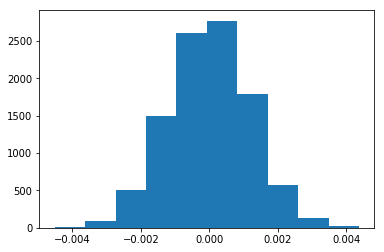

In [27]:
plt.hist(p_diffs);

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
obs_diff = (new_page['converted'].mean()) - (old_page['converted'].mean())
(p_diffs > obs_diff).mean()

0.90639999999999998

We have calculated a p-value of 0.906. This identifies the proportion of values in the null distribution that were greater than the observed difference in the conversion rate for the new page compared to the old page. 

With a Type 1 error rate of 5% (alpha = 0.05), the p-value is clearly greater than alpha. Therefore, we fail to reject the null hypothesis, as there is no evidence that there is a significant difference between the conversion rates of the new and old page. 

Now, we will perform the same analysis using the statsmodels package.

First, we want to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [14]:
import statsmodels.api as sm

convert_old = old_page.query('converted == 1')['converted'].count()
convert_new = new_page.query('converted == 1')['converted'].count()
n_old = old_page.count()[0]
n_new = new_page.count()[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Use `stats.proportions_ztest` to compute the test statistic and p-value. 

In [15]:
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new ], [n_old, n_new])
z_score, p_value

(1.3109241984234394, 0.18988337448195103)

Although the p-values differ between the two tests, both tests conclude that we fail to reject the null hypothesis. At a significance level of 95%, a z-score would have to fall outside of the range (-1.96, 1.96) to be considered significant. The z-value calculated in this test (1.31) falls within that range, and therefore, the difference between the conversion rates is concluded to be insignificant. 

<a id='regression'></a>
### Part III - A regression approach

We will now perform this analysis using regression.<br><br>

Logistic regression should be performed, as this method is used to predict one of two outcomes. In this case, conversion or no conversion. 

The goal is to use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives.

We first need to create a column for the intercept, and create a dummy variable column for which page each user received.  

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

In [26]:
#Add an intercept column 
df2['intercept'] = 1
#Add an ab_page column, which is 1 when an individual receives the treatment and 0 if control
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Import the regression model.  Instantiate the model, and fit the model using the two newly created columns to predict whether or not an individual converts.

In [17]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

Provide model summary.

In [18]:
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        00:22:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

Model diagnostics: 

In [29]:
y = df2['converted']
X = df['ab_page']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

NameError: name 'ab_page' is not defined

Hypotheses and p-value: 

The p-value associated with ab_page is 0.19. For the logistic regression model, the p-value helps to determine whether or not there's a relationship between the X variables and the Y variable. This differs from Part II in which it was tested whether or not there was a difference in the conversion rate for the new page compared to the old page.

Now, we will consider the potential benefits/drawbacks of additing additional elements to our model.

Other factors should be considered in a regression model in order to better explain the outcome, and the R squared value. There are often several factors that can contribute to the determination of the outcome, rather than a single variable. However, the greater the number of terms in a model, the more complicated it may become. It is important to consider how great of an influence each factor makes and whether it is significant to the model. 

g. Now along with testing if the conversion rate changes for different pages,  we will also add an effect based on which country a user lives. 

In [19]:
#Read in dataset containing country/user data
df_c = pd.read_csv('countries.csv')
df_c.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
#There are 3 potential country values 
df_c['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [20]:
df3 = df2.join(df_c.set_index('user_id'), on='user_id')

In [21]:
#Create dummy variables for country 
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])

In [22]:
#Fit model 
log_mod2 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK']])
results2 = log_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 16 Oct 2018   Pseudo R-squ.:               2.323e-05
Time:                        00:22:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

Model Diagnostics: 

In [32]:
y = df3['converted']
X = df3[['ab_page', 'US', 'UK']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

In [34]:
logmod = LogisticRegression()
logmod.fit(X_train, y_train)
y_preds = logmod.predict(X_test)

print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(accuracy_score(y_test, y_preds))
confusion_matrix(y_test, y_preds)

0.0
0.0
0.879348910837


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[25553,     0],
       [ 3506,     0]])

Although this model only allows us to obtain the accuracy score and confusion matrix; the accuracy score is high. When examining the p-values of the x variables, it does not appear that any of the values would be considered significant, the p-values for the US and UK are lower than the p-value for ab_page. 

We would now like to look at an interaction between page and country to see if there significant effects on conversion. 

In [33]:
df3['ab_US'] = df3['US'] * df3['ab_page']
df3['ab_UK'] = df3['UK'] * df3['ab_page']

log_mod3 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK', 'ab_US', 'ab_UK']])
results3 = log_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 16 Oct 2018   Pseudo R-squ.:               3.482e-05
Time:                        00:43:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
ab_US          0.0469      0.054      0.872      0.383      -0.059       0.152
ab_UK          0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

In [35]:
y2 = df3['converted']
X2 = df3[['ab_page', 'US', 'UK', 'ab_US', 'ab_UK']]

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.10)

In [36]:
logmod2 = LogisticRegression()
logmod2.fit(X_train, y_train)
y_preds = logmod2.predict(X_test)

print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(accuracy_score(y_test, y_preds))
confusion_matrix(y_test, y_preds)

0.0
0.0
0.88048453147


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[25586,     0],
       [ 3473,     0]])

The accuracy score did improve for this model compared to the previous model. However, in adding the interaction terms, the  p-values for the countries increased significantly, which would imply a decreased significance for each term. 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])